# PyTorch for basic classification
Continuing from the last classification example, let's look at a more complicated case in which the classes are not linearly seperable.

We're going to require more than a single layer to solve this problem, so implementing a model in Numpy will become a bit complex; instead we'll switch to using PyTorch, which automatically tales care of computing gradients, and provides basic classes for building more complex networks.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from typing import *
from fastprogress import progress_bar
from collections import deque

import torch
from torch import nn, Tensor, optim
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader, Dataset
from torch.nn import BCELoss

In [2]:
n = 200
r = np.linspace(0.1,5, n)+np.random.normal(scale=0.3, size=n)

In [3]:
t = np.linspace(-np.pi, np.pi, n)
x0 = np.array(list(zip(r*np.cos(t), r*np.sin(t), np.ones_like(t))))

In [4]:
t = np.linspace(0, 2*np.pi, n)
x1 = np.array(list(zip(r*np.cos(t), r*np.sin(t), np.zeros_like(t))))

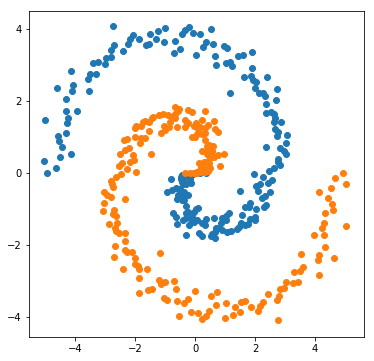

In [5]:
plt.figure(figsize=(6,6))
plt.scatter(x0[:,0], x0[:,1])
plt.scatter(x1[:,0], x1[:,1]);

Plotting the pseudodata in 2D space and using color indicate the class of the datapoints, we can see that no single straight line can be used to divide accurately the two classes. Instead we need some non-linear boundary to correctly predict the classes.

This could still be done using the Numpy-based neural network we had last time, however we'll need a few more neurons and several more layers than before, and working out all the derivatives manually would quickly become tiresome.

Instead we can use an autograd tensor library like Pytorch or Tensorflow, which will automatically compute the derivatives for us, as well as provide much quicker (accelerator backed) computation than Numpy can provide.

In [6]:
d = np.vstack((x0, x1))
np.random.shuffle(d)

In [7]:
x = d[:,0:2]
y = d[:,2].astype(int)

`x` are our inputs for the network - the position of the points in 2D space

`y` are the target for the network - the classes for the corresponding points

In [8]:
x[:10], y[:10]

(array([[-0.70104769, -3.00886694],
        [ 2.53980488,  1.67897875],
        [ 2.68500387,  2.02957916],
        [-2.12813184, -2.2138255 ],
        [-3.03203635, -0.83384604],
        [ 0.53865976,  3.99007524],
        [ 0.05948844,  1.07553724],
        [-2.44148024,  0.27090747],
        [ 3.01226605, -3.03613755],
        [ 0.6702557 , -1.64562859]]), array([0, 1, 1, 0, 0, 1, 0, 0, 0, 1]))

In the previous example, we evaluated model performance using the entire dataset. Whilst this provides a very accurate evaluation of the model performance, it can be quite slow and also increases the probability of *memorising* the training data, reducing performance on unseen data (poor *generalisatioon*).

This time we are going to use *stochastic* gradient descent using subsamples of the training data (mini-batches). To do so, it will be useful to build a class to handle iterating through our data. PyTorch provides an abstract [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class, from which we will inherit.

`Dataset` classes are designed to work with PyTorch's [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class, which provides various functionalities, such as running multiple cpu workers to load data which the current batch is being evaluated. These usually call the `__get_item__` method to load individual datapoints, but for low-memory data such as ours, however, I have found it quicker to call a `__iter__` method directly to return slices of the data.

One technical point for PyTorch is that we are responsible for moving objects to and from devices, like CPU and GPU. This includes data stored in Tensors, neural networks, et cetera. This can be accomplished using the `to(device)` method, where `device` is e.g. `torch.device('cuda')` for GPU and `torch.device('cpu')` for CPU.
Normally it is quicker to perform operations on a GPU, however each move to and from devices requires some time.

Note that one complete use of the training data is referred to as one *epoch*, and training often continues for many epochs.

In [19]:
class NPDataset(Dataset):
    r'''
    Dataset for dealing with Numpy arrays
    
    Arguments:
        x: input data
        y: Optional target data
        shuffle: whether to shuffle input and target data prior to iteration
        bulk_move: whether to move entire dataset to device at start of iteration (quicker) or move batch by batch (memory efficient)
        bs: batchsize, number of datapoints per minibatch
        device: set to either cuda or cpu, or leave as None for cuda if available else cpu
        drop_last: whether to drop last batch if it is smaller than bs
    '''
    
    def __init__(self, x:np.ndarray, y:Optional[np.ndarray]=None, shuffle:bool=True, bulk_move:bool=True, bs:int=64,
                 device:Optional[torch.device]=None, drop_last:bool=True):
        self.shuffle,self.bulk_move,self.bs,self.drop_last = shuffle,bulk_move,bs,drop_last
        if device is None: self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        else:              self.device = device
        self.x = x.astype('float32')
        if len(self.x.shape) == 1: self.x = self.x[:,None]
        if y is None:
            self.y = y
        else:
            self.y = y.astype('float32')
            if len(self.y.shape) == 1: self.y = self.y[:,None]

    def __len__(self) -> int:
        r'''
        Returns the number of datapoints in the dataset
        '''
        
        return len(self.x)

    def __getitem__(self, idx:int) -> Tuple[Any,Any]:
        r'''
        Returns a single datapoint at the requested index
        '''
        
        if self.y is None: return self.x[idx]
        else:              return self.x[idx], self.y[idx]
        
    def __iter__(self) -> Tuple[Tensor,Tensor]:
        r'''
        Iterates through the entire (shuffled) dataset, yielding minibatches of Tensors on device
        '''
        
        if self.shuffle:
            data = list(zip(self.x, self.y))
            np.random.shuffle(data)
            inputs, targets = zip(*data)
        else:
            inputs, targets = self.x, self.y
            
        if self.bulk_move:  # Moves entire dataset to device
            inputs  = Tensor(inputs).to(self.device)
            if targets is not None: targets = Tensor(targets).to(self.device)
            if self.drop_last:
                for i in range(0, len(inputs)-self.bs+1, self.bs):
                    if targets is not None: yield inputs[i:i+self.bs], targets[i:i+self.bs]
                    else:                   yield inputs[i:i+self.bs]
            else:
                for i in range(0, len(inputs)+1, self.bs):
                    if targets is not None:
                        if i+self.bs < len(inputs): yield inputs[i:i+self.bs], targets[i:i+self.bs]
                        else:                       yield inputs[i:],          targets[i:]
                    else:
                        if i+self.bs < len(inputs): yield inputs[i:i+self.bs]
                        else:                       yield inputs[i:]
        else:
            if self.drop_last:
                for i in range(0, len(inputs)-self.bs+1, self.bs):
                    if targets is not None:
                        yield Tensor(inputs[i:i+self.bs]).to(self.device), Tensor(targets[i:i+self.bs]).to(self.device)
                    else:
                        yield Tensor(inputs[i:i+self.bs]).to(self.device)
            else:
                for i in range(0, len(inputs)+1, self.bs):
                    if targets is not None:
                        if i+self.bs < len(inputs):
                            yield Tensor(inputs[i:i+self.bs]).to(self.device), Tensor(targets[i:i+self.bs]).to(self.device)
                        else:
                            yield Tensor(inputs[i:]).to(self.device),          Tensor(targets[i:]).to(self.device)
                    else:
                        if i+self.bs < len(inputs): yield Tensor(inputs[i:i+self.bs]).to(self.device)
                        else:                       yield Tensor(inputs[i:]).to(self.device)                

Now we want to construct our neural network. PyTorch provides a generic [`nn.Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) class to act as basic building blocks for components of the NN. `nn.Module` has a `foward` method, where Tensors can be passed into the module transformed somehow and then returned. The transformation should depend on the `parameters` on the module, whose local gradients will be computed automatically. These parameters can then be adjusted using an optimiser to train the network. `forward` can either be called directly, or more conveniently via the overidden `()` operator, e.g. `my_module(x)`.

One of the basic modules is [`nn.Linear`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), which applies the transformation $w\cdot x+b$, where $x$ and $b$ are trainable parameters. There are also activation layers, such as `nn.ReLU`.

During the initialisation of our network, we need to define all the parameters, this can be done by explicitly declaring each component of the network:
```
self.l1 = nn.Linear(10,100)
self.a1 = nn.ReLU()
self.l2 = nn.Linear(100,100)
self.a2 = nn.ReLU()
...
```
This, however, makes it difficult to change the network without rewriting the class definition. [`nn.ModuleList`](https://pytorch.org/docs/stable/nn.html#torch.nn.ModuleList) and [`nn.ModuleDict`](https://pytorch.org/docs/stable/nn.html#torch.nn.ModuleDict) can be combined with loops or list comprehension to declare parameters without explicitly defining them as separate variables in code, e.g.:
```
self.linear_layers     = nn.ModuleList([nn.Linear(10 if i == 0 else 100, 100) for i in range(5)])
self.activation_layers = nn.ModuleList([nn.Relu() for i in range(5)])
```

During the `forward` method the incoming tensor must be passed through the various components of the network. Since they are also `nn.Module` classes, we call their `forawrd` methods, e.g.:
```
x = l1(x)
x = a1(x)
x = l2(x)
x = a2(x)
```
or
```
for i in range(5):
    x = self.linear_layers[i](x)
    x = self.activation_layers[i](x)
```

For very simple networks, it can be useful to use the [`nn.Sequential`](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential) class, which takes several modules and when `forward` is called, will pass the input through the first module, pass its output into the next module and so on.

This can be useful to simplify basic components of the network and when being agnostic to hyperparameters of the network, e.g. both of these examples will act appropriately when `self.layer1.forward` is called:
```
self.layer1 = nn.Sequential(nn.Linear(10,100), nn.ReLU())
self.layer1 = nn.Sequential(nn.Linear(10,100), nn.ReLU(), nn.Batchnorm1d(), nn.Dropout(0.2))
```
We can even compact the all the layers into a `nn.Sequential`:
```
self.layers = nn.Sequential(*[nn.Sequential(nn.Linear(10 if i == 0 else 100,100), nn.ReLU()) for i in range(5)])
```
and during `forward`:
```
return self.layers(x)
```

Also be aware that the foward methods are not `fixed` and can act differently based on the incoming data and other factors. E.g. to pass different parts of the incoming tensor through different modules, we can do:
```
x1 = self.layers1(x[:,:5])  # Pass columns 0-4 through one set of layers
x2 = self.layers2(x[:,5:])  # Pass the other columns through a different set of layers
return torch.cat((x1, x2), dim=-1)  # Concatenate the two tensors back together
```

Another slight complication is that weights and biases must be initialised by the user, PyTorch applies a default initialisation, but it is not guaranteed to be optimal.

In [20]:
class NN(nn.Module):
    r'''
    Full-connected neural network with user-defined depth and width (same width for all dense layers).
    User-configurable output activation function (None for regression, nn.Sigmoid for classification).
    Internal activations are nn.ReLU
    
    Arguments:
        n_int: number of inputs
        depth: number of hidden layers
        width: size of hidden layers
        n_out: width of output layer
        out_act: activation function for output layer (if any)
    '''
    
    def __init__(self, n_in:int, depth:int, width:int, n_out:int, out_act:Optional[Callable[[],nn.Module]]):
        super().__init__()  # nn.Module.__init__ must always be called to correctly initialise class
        if out_act is None: out_act = lambda: None
        self.layers = nn.Sequential(*[self._get_layer(n_in      = n_in      if d   == 0       else width,
                                                      n_out     = width     if d <  depth else n_out,
                                                      act       = nn.ReLU() if d <  depth else out_act(),
                                                      out_layer = d == depth)
                                      for d in range(depth+1)])
        
    @staticmethod
    def _get_layer(n_in:int, n_out:int, act:Optional[nn.Module], out_layer:bool) -> nn.Sequential:
        r'''
        Returns a correctly initialised dense layer and optionally an activation layer, as a Sequential model
        '''
        
        layers = []
        
        # Create a single layer and initialise weights and biases
        layers.append(nn.Linear(n_in, n_out))
        if out_layer: nn.init.xavier_normal_(layers[-1].weight)
        else:         nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='relu')
        nn.init.zeros_(layers[-1].bias)
        
        # Add activation funtion
        if act is not None: layers.append(act)
        return nn.Sequential(*layers)
    
    def forward(self, x:Tensor) -> Tensor:
        r'''
        Passing input tensor through the neural network and returns the output
        '''
        
        return self.layers(x)

In [21]:
net = NN(n_in=2, depth=2, width=10, n_out=1, out_act=nn.Sigmoid); net

NN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)

So, we can create a neural network, but we don't have any way to train it. One way to make is more user friendly is to wrap it in another class which has useful methods.

Let's write a class which will train the network, and provide methods to predict and evaluate as well. The key components for the fitting method are the loss (how to measure performance) and the optimiser (how to alter the network parameters based on the loss).

Basic loss functions are available, such as [`MSELoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.MSELoss) and [`BCELoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss).

Common opimisers are available, and documented (https://pytorch.org/docs/stable/optim.html). Previously, we used basic Gradient Descent, however this can be sometime slow to converge. Instead [Adam](https://arxiv.org/abs/1412.6980) will accumulate 'momentum' during updates allowing for faster movement down the gradient and will automatically scale the learning rate based on past gradients. Again it's normally quite a good default choice.

The `nn.Module` class has to modes, `eval` and `train` to control aspects which should only be active during specific operations, and these can be switched between by calling the `eval()` and `train()` methods.

In [22]:
class Model():
    r'''
    Class wrapping a neural network (nn.Module) providing fitting and prediction methods
    
    Arguments:
        model: the network to wrap
        device: set to either cuda or cpu, or leave as None for cuda if available else cpu
        bulk_move: whether to move entire dataset to device at start of iteration (quicker) or move batch by batch (memory efficient)
    '''
    
    def __init__(self, model:nn.Module, device:Optional[torch.device]=None, bulk_move:bool=True):
        if device is None: self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        else:              self.device = device
        self.model = self.to_device(model, self.device)
        self.opt = optim.Adam(self.model.parameters())
        self._n_out = self.get_n_out()
        self.bulk_move = bulk_move
        
    def __repr__(self) -> str:
        return f'''Model:\n{self.model}
        \n\nNumber of trainable parameters: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}
        \n\nOptimiser:\n{self.opt}
        '''
    
    def get_n_out(self) -> None:
        r'''
        Gets the number of outputs of the network
        '''
        
        l = deque(self.model.parameters(), maxlen=1).pop()
        return len(l.shape)
    
    @staticmethod
    def to_device(x:Union[Tensor,List[Tensor]], device:torch.device) -> Union[Tensor,List[Tensor]]:
        r'''
        Recursively places Tensor(s) onto device

        Arguments:
            x: Tensor(s) to place on device

        Returns:
            Tensor(s) on device
        '''

        if x is None: return x
        if isinstance(x, list): return [Model.to_device(o, device) for o in x]
        return x.to(device)
    
    @staticmethod
    def to_np(x:Tensor) -> np.ndarray:
        r'''
        Converts Tensor x to a Numpy array

        Arguments:
            x: Tensor to convert

        Returns:
            x as a Numpy array
        '''

        return x.cpu().detach().numpy()
    
    def set_lr(self, lr:float) -> None:
        r'''
        Sets learning rate of optimiser
        '''

        self.opt.param_groups[0]['lr'] = lr
    
    def fit(self, x:np.ndarray, y:np.ndarray,
            lr:float, batchsize:int, loss_fn:_Loss, n_epochs:int,
            x_val:Optional[np.ndarray]=None, y_val:Optional[np.ndarray]=None) -> Tuple[List[float],List[float]]:
        r'''
        Fits model to data (optionally using validation data) for a set number of epochs.
        
        Arguments:
            x: training inputs
            y: training targets
            lr: learning rate
            batchsize: size of minibatches
            loss_fn: Loss function to use
            n_epochs: number of epochs to train
            x_val: optional validation inputs
            y_val: optional validation targets
        
        Returns:
            Tuple of train and validation losses
        '''
        
        trn_losses,val_losses = [],[]
        trn_dl = NPDataset(x,y, bs=batchsize, shuffle=True, bulk_move=self.bulk_move, device=self.device)
        self.set_lr(lr)
        
        epoch_pb = progress_bar(range(n_epochs), display=True, leave=True)
        for e in epoch_pb:
            losses = []  # Holder for losses during epoch
            self.model.train()  # Put model into train mode (local gradients saved during forward pass, dropout active, etc.)
            for x, y in trn_dl:  # Loop over batches
                x,y = self.to_device(x, self.device),self.to_device(y, self.device)  # Put data on device
                y_pred = self.model(x)  # Run forward pass of network and get prediction
                loss = loss_fn(y_pred, y)  # Compute loss of prediction
                losses.append(loss.data.item())  # Get value of loss
                self.opt.zero_grad()  # Reset recorded gradients
                loss.backward()  # Propagate loss gradient backwards through network
                self.opt.step()  # Perform one update step to network parameters
            
            trn_losses.append(np.mean(losses))
            if x_val is not None:
                val_losses.append(self.evaluate(x_val,y_val, batchsize=batchsize, loss_fn=loss_fn))
                epoch_pb.comment = f'Epoch {e+1}, best loss: {np.min(val_losses):.4E}'
            else:
                epoch_pb.comment = f'Epoch {e+1}, best loss: {np.min(trn_losses):.4E}'
        self.plot_train_history([trn_losses,val_losses])
        return trn_losses,val_losses
    
    def evaluate(self, x:np.ndarray, y:np.ndarray, batchsize:int, loss_fn:_Loss) -> float:
        r'''
        Computes mean loss on network predicitons for data
        '''
        
        self.model.eval()  # Put model into eval mode no grads saved, dropout turned off, etc.
        loss = []
        dl = NPDataset(x,y, bs=batchsize, shuffle=True, bulk_move=self.bulk_move, device=self.device)
        for x, y in dl:  # Loop over batches
            x,y = self.to_device(x, self.device),self.to_device(y, self.device)  # Put data on device
            y_pred = self.model(x)  # Run forward pass of network and get prediction
            loss.append(loss_fn(y_pred, y).data.item())  # Get value of loss
        return np.mean(loss)
    
    def predict(self, x:np.ndarray, batchsize:Optional[int]=None) -> np.ndarray:
        r'''
        Computes preditions for network on data
        '''
        
        self.model.eval()  # Put model into eval mode no grads saved, dropout turned off, etc.
        if batchsize is None:  # Compute all predictions at once
            x = x.astype('float32')
            if len(x.shape) == 1: x = x[:,None]
            preds = self.model(self.to_device(Tensor(x), self.device))
        else:
            dl = NPDataset(x, bs=batchsize, shuffle=False, bulk_move=self.bulk_move, drop_last=False, device=self.device)
            preds = torch.zeros((len(x),self._n_out), device=self.device)
            for i, x in enumerate(progress_bar(dl, leave=True)):  # Loop over batches
                x = self.to_device(x, self.device)  # Put inputs on device
                ps = self.model(x)  # Run forward pass of network and get prediction
                if len(ps) == batchsize: preds[i*batchsize:(1+i)*batchsize] = ps
                else:                    preds[i*batchsize:]                = ps  # Last batch
        return self.to_np(preds)
    
    @staticmethod
    def plot_train_history(history:Tuple[List[float],List[float]]) -> None:
        r'''
        Plots loss evolution as a function of training epoch
        '''
        plt.figure(figsize=(16,9))
        plt.plot(history[0], label='Training')
        plt.plot(history[1], label='Validation')
        plt.legend(loc='upper right', fontsize=16)
        if history[0][0]/np.min(history[0]) > 50: plt.yscale('log', nonposy='clip')
        plt.grid(True, which="both")
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlabel("Epoch", fontsize=24)
        plt.ylabel("Loss", fontsize=24)
        plt.show()

In [23]:
model = Model(net); model

Model:
NN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)
        

Number of trainable parameters: 151
        

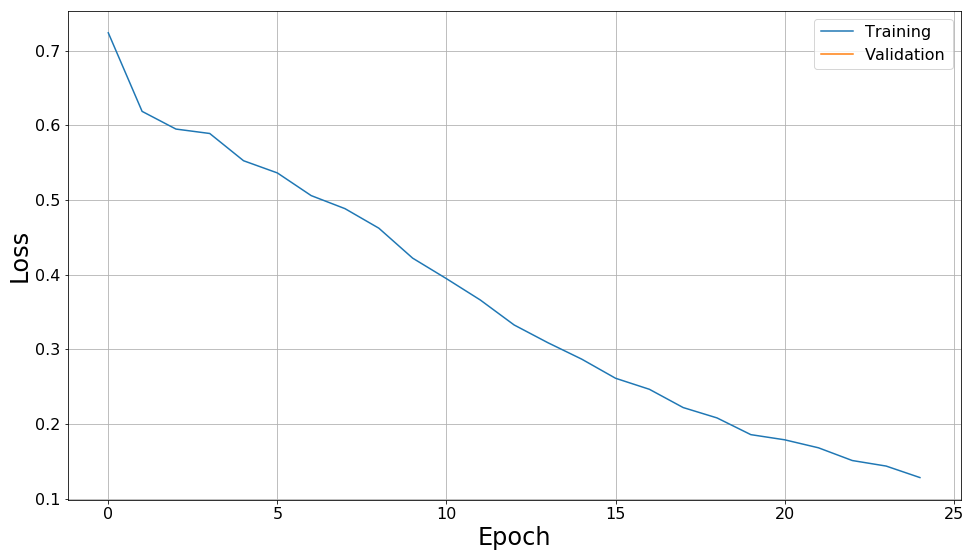

In [24]:
history = model.fit(x=x, y=y, batchsize=64, n_epochs=25, lr=0.01, loss_fn=BCELoss())

We can now see how well the model was able to identify the points.

In [25]:
preds = model.predict(x)

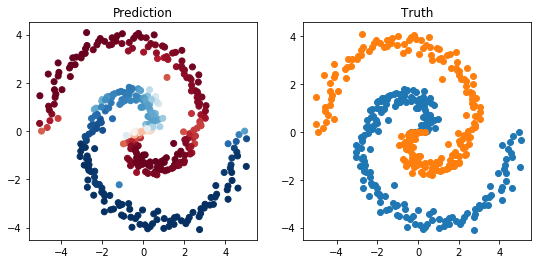

In [26]:
fig, axs = plt.subplots(1,2, figsize=(9,4))
axs[0].scatter(x[:,0], x[:,1], c=preds.squeeze(), cmap='RdBu_r')
axs[0].set_title('Prediction')
axs[1].scatter(x[y==0][:,0], x[y==0][:,1])
axs[1].scatter(x[y==1][:,0], x[y==1][:,1])
axs[1].set_title('Truth');

We could also see how the model would respond to data outside of what we used for training.

In [27]:
res = 50
a, b, pred_map = [], [], []

for i in np.linspace(x[:,0].min(), x[:,0].max(), res):
    x0 = i*np.ones((res,))
    x1 = np.linspace(x[:,1].min(), x[:,1].max(), res)
    pred_map += list(model.predict(np.array(list(zip(x0,x1)))).squeeze())
    a += list(x0)
    b += list(x1)

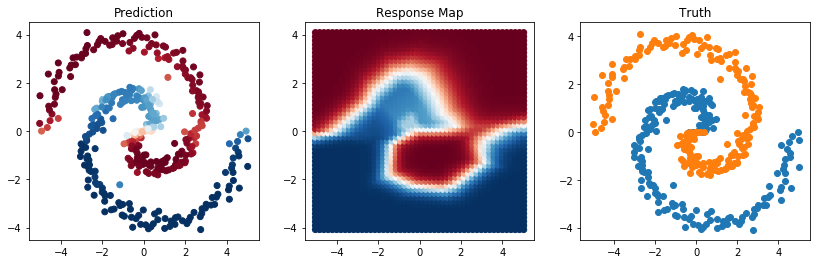

In [28]:
fig, axs = plt.subplots(1,3, figsize=(14,4))
axs[0].scatter(x[:,0], x[:,1], c=preds.squeeze(), cmap='RdBu_r')
axs[0].set_title('Prediction')
axs[1].scatter(a, b, c=pred_map, cmap='RdBu_r')
axs[1].set_title('Response Map')
axs[2].scatter(x[y==0][:,0], x[y==0][:,1])
axs[2].scatter(x[y==1][:,0], x[y==1][:,1])
axs[2].set_title('Truth');

Note how the response map indicates that the model does not try to extrapolate the spiral pattern, instead it would only work well for data similar to what saw during training, despite offering confident predictions in regions outside the training data. Neural networks are not magic or intelligent, just powerful tools.